# Resonance frequencies of a metal cylindrical cantilever

Here we explore a practical example of importing and analyzing data taken from an oscilloscope (in this case, Instek GDS-1052-U 50MHz Digital Oscilloscope 2CH). We make use of the fast Fourier transform (FFT) algorithm from the numpy library to learn about the natural frequencies that a cantilever ("diving board") makes when perturbed.

What happens here:
* import data from csv file
* select a range of interest (ROI) by user-defined start and stop times
* plot ROI for confirmation
* fast Fourier transform (FFT) of ROI
* save FFT result as a data file

This can be repeated for several files, then:
* show FFT for multiple analyzed files
* analyze spectrum -- e.g., find peak position, estimate Q-factor
* estimate fundamental resonance frequency using a formula

In [2]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
%matplotlib inline

In [36]:
# user-modified area:
filename= 'DS0004.csv'

In [37]:
# import data from csv file
data = np.genfromtxt(filename,delimiter=',',skip_header=17 )
x_values = data[:,0]
y_values = data[:,1]

Just a simple plot of the imported data, no fancy things like axis labels or legends (we'll do that in a moment). The 'x-axis' is time, in seconds.

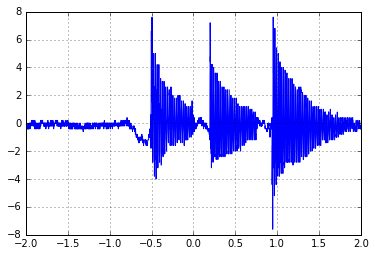

In [38]:
plt.plot(x_values, y_values)
plt.grid()
plt.show()

Define the range of interest (ROI) by defining start and stop times that you are interested in analyzing:

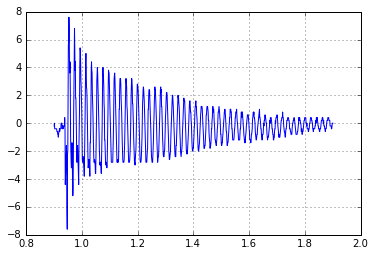

In [54]:
start_time, stop_time = 0.9, 1.9

start_time_idx = np.where(x_values > start_time)[0][0]
stop_time_idx = np.where(x_values > stop_time)[0][0]
x_ROI = x_values[start_time_idx:stop_time_idx]
y_ROI = y_values[start_time_idx:stop_time_idx]

plt.plot(x_ROI,y_ROI)
plt.grid()
plt.show()
# uncomment the following line to save the image as a *.png file:
# plt.savefig('range of interest.png',dpi=400)

Next we perform the fast Fourier transform (FFT) on data in the ROI do find out the frequency content of this waveform.

In [55]:
Y_FFT = np.fft.fft(y_ROI)
DT = x_ROI[1]-x_ROI[0]
freq = np.fft.fftfreq(x_ROI.shape[-1])/DT

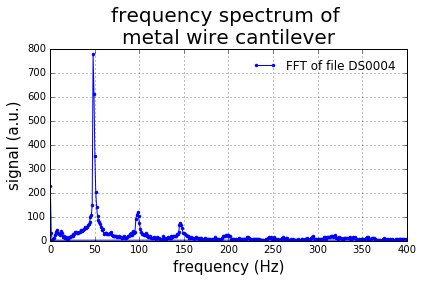

In [56]:
title = 'frequency spectrum of \nmetal wire cantilever'
xaxis_label = 'frequency (Hz)'
yaxis_label = 'signal (a.u.)'

plt.plot(freq,np.abs(Y_FFT),'.-',label='FFT of file '+filename[0:6])

plt.xlabel(xaxis_label,fontsize=15)
plt.ylabel(yaxis_label,fontsize=15)
plt.grid()
plt.title(title,fontsize=20)

plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 

plt.xlim([0,400])
plt.legend(frameon=False,loc='best') 
plt.tight_layout() 

# save the figure as a png file. It will be saved to the same directory as your program.
# plt.savefig('mydata.png',dpi=400)

# save the analyzed data to a text file with a name corresponding to the original filename
np.savetxt('FFT_'+filename[0:6]+'.txt', (freq,np.abs(Y_FFT)), delimiter=',',fmt='%.4e')

This concludes the analysis for each file individually. This can be repeated for multiple files, carefully choosing a new ROI each time, and FFT files will be saved. These files can then be compared and analyzed with the following code:

In [63]:
# list the filenames 
file_number_max_idx = 5
filenames = ['DS{:04d}'.format(x) for x in range(file_number_max_idx)]

In [58]:
# this is a procedural approach

fft_data = {}

for filename in filenames:
    data = np.genfromtxt('FFT_{}.txt'.format(filename),
                         delimiter=',',unpack=True)
    fft_data[filename] = (data[:,0], data[:,1])
    

In [64]:
# this is a functional approach -- less prone to errors!

def load_data(filename):
    data = np.genfromtxt('FFT_{}.txt'.format(filename),
                         delimiter=',',unpack=True)
    return data[:,0], data[:, 1]

fft_data = {filename:load_data(filename) for filename in filenames}

In [65]:
fft_data.keys()

dict_keys(['DS0004', 'DS0000', 'DS0003', 'DS0002', 'DS0001'])

In [66]:
fft_data['DS0000'][1]

array([ 5421.9,  1837.9,  1857.8, ...,  2065.4,  1857.8,  1837.9])

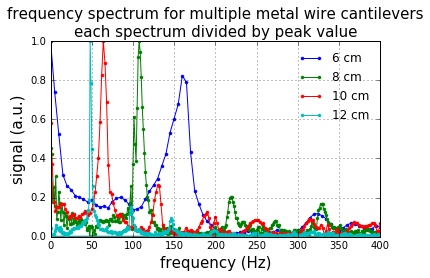

In [78]:
label_dict = {0:6,1:6,2:8,3:10,4:12}

title = 'frequency spectrum for multiple metal wire cantilevers\neach spectrum divided by peak value'
xaxis_label = 'frequency (Hz)'
yaxis_label = 'signal (a.u.)'

for filename in filenames[1:]:
    fft_x = fft_data[filename][0]
    fft_y = fft_data[filename][1]
    # divide by max so FFT data can be displayed on same scale
    fft_y = fft_y/np.max(fft_y)
    plt.plot(fft_x,fft_y,'.-',
                 label='{} cm'.format(label_dict[int(filename.strip('DS'))]))

plt.xlabel(xaxis_label,fontsize=15)
plt.ylabel(yaxis_label,fontsize=15)
plt.grid()
plt.title(title,fontsize=15)

plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 

plt.legend(frameon=False,loc='best') 
plt.xlim([0,400])
# plt.ylim([1,10000])
plt.tight_layout() 

# save the figure as a png file. It will be saved 
# to the same directory as your program.
plt.savefig('cantilever fft data.png',dpi=400)

Now we have plotted the FFT data for multiple frequencies. Let's try finding the peaks for each and confirm on the plot that we have found the peak for each:

In [99]:
resonance_freqs = np.zeros(np.size(filenames))
resonance_freqs

array([ 0.,  0.,  0.,  0.,  0.])

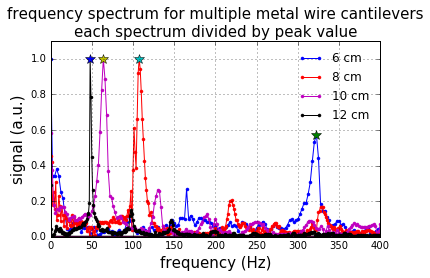

In [118]:
label_dict = {0:6,1:6,2:8,3:10,4:12}

begin_spectrum_analyze_idx = 3
resonance_freqs = np.zeros(np.size(filenames))

for idx,filename in enumerate(filenames):
#     print(idx)
    fft_x = fft_data[filename][0]
    fft_y = fft_data[filename][1]
    # divide by max so FFT data can be displayed on same scale
    fft_y = fft_y/np.max(fft_y)
    max_index = fft_y[begin_spectrum_analyze_idx:].argmax()+begin_spectrum_analyze_idx
    
#     resonance_freqs.append(fft_x[max_index])
    resonance_freqs[idx] = fft_x[max_index]
    if idx != 1:
        plt.plot(fft_x,fft_y,'.-',
                 label='{} cm'.format(label_dict[int(filename.strip('DS'))]))
        plt.plot(fft_x[max_index],fft_y[max_index],'*',markersize=10)

plt.xlabel(xaxis_label,fontsize=15)
plt.ylabel(yaxis_label,fontsize=15)
plt.grid()
plt.title(title,fontsize=15)

plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10) 

plt.legend(frameon=False,loc='best') 
plt.xlim([0,400])
plt.ylim([0,1.1])
plt.tight_layout() 

# save the figure as a png file. It will be saved 
# to the same directory as your program.
plt.savefig('cantilever fft data.png',dpi=400)

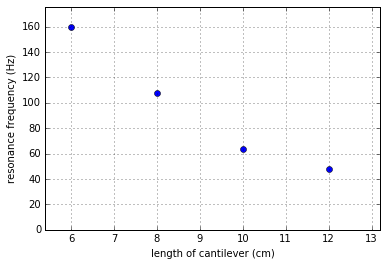

In [129]:
length_list = []
for i in label_dict:
    length_list.append(label_dict[i])
plt.plot(length_list[1:],resonance_freqs[1:],'o')
plt.grid()
plt.xlim([np.min(length_list[1:])*.9,np.max(length_list[1:])*1.1])
plt.ylim([0,np.max(resonance_freqs[1:])*1.1])
plt.xlabel('length of cantilever (cm)')
plt.ylabel('resonance frequency (Hz)')

This trend is more or less how we'd expect: longer cantilevers oscillate at lower frequencies. Like Hooke's law: more mass, lower resonance. Let's go a layer deeper and see whether the length scales as 1/length^2...

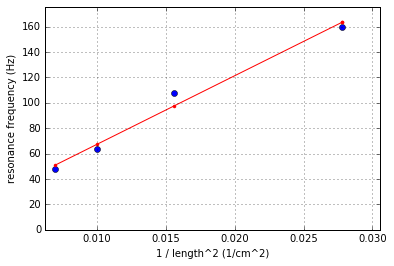

In [156]:
length_inv_sqrd=[]
for i in length_list:
    length_inv_sqrd.append(i**(-2) )

length_inv_sqrd = np.asarray(length_inv_sqrd)
p = np.polyfit(length_inv_sqrd[1:],resonance_freqs[1:],1)   # these are the polynomial coefficients for a linear-order polyomial
m = p[0]
b = p[1]
yfit = m*length_inv_sqrd + b    # constructing the array for the polynomial fit curve

plt.plot(length_inv_sqrd[1:],resonance_freqs[1:],'o')
plt.plot(length_inv_sqrd,yfit,'.-r',label='linear fit, y = %2.2f*x + %2.2f'%(m,b))
plt.grid()
plt.xlim([np.min(length_inv_sqrd[1:])*.9,np.max(length_inv_sqrd[1:])*1.1])
plt.ylim([0,np.max(resonance_freqs[1:])*1.1])
plt.xlabel('1 / length^2 (1/cm^2)')
plt.ylabel('resonance frequency (Hz)')

In [154]:
yfit

array([ 163.41166775,  163.41166775,   97.73934569,   67.34244234,
         50.83054422])

In [97]:
resonance_freqs

array([ 159.84 ,  107.49 ,   63.994,   48.   ,    0.   ])

Using a formula from this reference for the resonance frequencies of a cantilever:

http://iitg.vlab.co.in/?sub=62&brch=175&sim=1080&cnt=1

some thoughts: 
* input coeff from fit (freq vs 1/length^2), diameter, and density, output Young's modulus

In [160]:
d=1.5*10**-3
L = 12*10**-2

E=0.69*10**11  # N/m^2
rho = 2700  # kg/m^3

I=np.pi/64*d**4
A = np.pi*(d/2)**2

freq_mult = (1/(2*np.pi))* np.sqrt(E*I/(rho*A*L**4))
freq1 = 1.875**2 * freq_mult
freq2 = 4.694**2 * freq_mult
freq3 = 7.855**2 * freq_mult
[freq1,freq2,freq3]

[73.660407090512408, 461.65520993967482, 1292.7779895187582]

In [165]:
print("Estimated resonance frequencies")
print("Fundamental: %.2f Hz"%(freq1))
print("Second: %.2f Hz"%(freq2))
print("Third: %.2f Hz"%(freq3))

Estimated resonance frequencies
Fundamental: 73.66 Hz
Second: 461.66 Hz
Third: 1292.78 Hz
